In [1]:
import tensorflow as tf
import math
import matplotlib.pyplot as plt
tf.random.set_seed(52)

2022-08-12 12:53:43.515472: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-12 12:53:43.515726: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(-0.5, 1065.5, 799.5, -0.5)

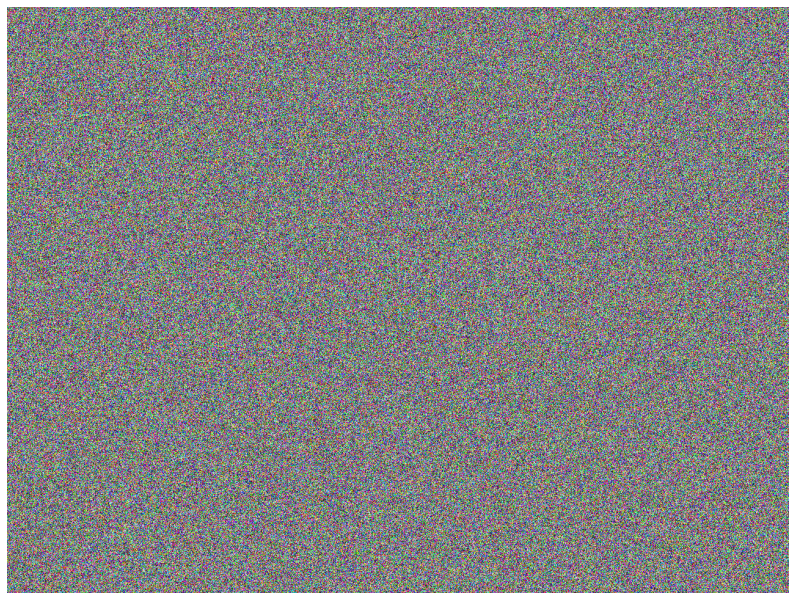

In [2]:
input_image = tf.random.uniform((1, 800, 1066, 3), dtype=tf.float32, minval=0, maxval=1)
plt.figure(figsize=(14, 14))
plt.imshow(input_image[0])
plt.axis("off")

In [3]:
backbone = tf.keras.applications.ResNet50(input_shape=(None, None, 3), include_top=False, weights="imagenet",)
conv1x1 = tf.keras.layers.Conv2D(256, 1)
backbone_feature = conv1x1(backbone(input_image))
backbone_feature.shape

TensorShape([1, 25, 34, 256])

In [4]:
row_embed = tf.Variable(tf.random.uniform([50, 256//2]))
col_embed = tf.Variable(tf.random.uniform([50, 256//2]))

cated = tf.concat([tf.tile(tf.expand_dims(col_embed[:34], 0), [25, 1, 1]), tf.tile(tf.expand_dims(row_embed[:25], 1), [1, 34, 1])], axis = -1)
cated = tf.expand_dims(tf.reshape(cated, [25*34, -1]), 0)
cated = tf.repeat(cated, repeats=[1], axis=0)
src = cated + tf.reshape(backbone_feature, [1, 25*34, -1])
src.shape

TensorShape([1, 850, 256])

In [5]:
query_pos = tf.Variable(tf.random.uniform([100, 256]))
tgt = tf.expand_dims(query_pos, 0)
tgt = tf.repeat(tgt, repeats=[1], axis=0)
tgt.shape

TensorShape([1, 100, 256])

In [6]:
class backbone(tf.keras.layers.Layer):
    def __init__(self, hidden_dim, input_w, input_h):
        super(backbone, self).__init__()
        self.input_w, self.input_h = input_w, input_h
        self.hidden_dim = hidden_dim
        self.backbone = tf.keras.applications.ResNet50(input_shape=(input_w, input_h, 3), include_top=False, weights="imagenet",)
        self.conv1x1 = tf.keras.layers.Conv2D(hidden_dim, 1)
        
        self.row_embed = tf.Variable(tf.random.uniform([50, hidden_dim//2]))
        self.col_embed = tf.Variable(tf.random.uniform([50, hidden_dim//2]))
    def call(self, input_image):
        backbone_feature = self.conv1x1(self.backbone(input_image))
        cated = tf.concat([tf.tile(tf.expand_dims(self.col_embed[:math.ceil(self.input_h/32)], 0), [math.ceil(self.input_w/32), 1, 1]),
                           tf.tile(tf.expand_dims(self.row_embed[:math.ceil(self.input_w/32)], 1), [1, math.ceil(self.input_h/32), 1])], axis = -1)
        cated = tf.expand_dims(tf.reshape(cated, [math.ceil(self.input_w/32)*math.ceil(self.input_h/32), -1]), 0)
        cated = tf.repeat(cated, repeats=[1], axis=0)
        src = cated + tf.reshape(backbone_feature, [1, math.ceil(self.input_w/32)*math.ceil(self.input_h/32), -1])
        return src

In [7]:
src = backbone(256, 800, 1066)(input_image)
src.shape

TensorShape([1, 850, 256])

In [8]:
def scaled_dot_product_attention(query, key, value, mask):
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)
    if mask is not None:
        logits += (mask * -1e9)

    attention_weights = tf.nn.softmax(logits, axis=-1)
    output = tf.matmul(attention_weights, value)
    return output

In [9]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, query, key, value, mask):
        batch_size = tf.shape(query)[0]

        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.d_model))

        outputs = self.dense(concat_attention)
        return outputs

In [10]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dropout = tf.keras.layers.Dropout(rate)
        self.ffn2 = tf.keras.layers.Dense(d_model)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
      
    def call(self, x, training, mask=None):
        src2 = self.self_attn(x, x, x, mask)
        x = x + self.dropout1(src2, training)
        x = self.layernorm1(x)

        src2 = self.ffn2(self.dropout(self.ffn1(x), training))

        x = x + self.dropout2(src2, training)
        x = self.layernorm2(x)
        return x

In [11]:
encoder_layer_output = EncoderLayer(256, 8, 2048)(src)
encoder_layer_output.shape

TensorShape([1, 850, 256])

In [12]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
          
    def call(self, x, training, mask=None):
        x = self.dropout(x, training=training)
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)
        return x

In [13]:
encoder_output = Encoder(num_layers=2, d_model=256, num_heads=8, dff=2048)(src)
encoder_layer_output.shape

TensorShape([1, 850, 256])

In [14]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.mha = MultiHeadAttention(d_model, num_heads)

        self.ffn1 = tf.keras.layers.Dense(dff, activation='relu')
        self.dropout = tf.keras.layers.Dropout(rate)
        self.ffn2 = tf.keras.layers.Dense(d_model)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
      
    def call(self, tgt, enc_output, training,  look_ahead_mask=None, padding_mask=None):
        tgt2 = self.self_attn(tgt, tgt, tgt, mask=look_ahead_mask)

        tgt = tgt + self.dropout1(tgt2)
        tgt = self.layernorm1(tgt)

        tgt2 = self.mha(tgt, enc_output, enc_output, mask=look_ahead_mask)

        tgt = tgt + self.dropout2(tgt2)
        tgt = self.layernorm2(tgt)
        tgt2 = self.ffn2(self.dropout(self.ffn1(tgt),training))
        tgt = tgt + self.dropout3(tgt2)
        tgt = self.layernorm3(tgt)
        return tgt

In [15]:
decoder_layer_output = DecoderLayer(256, 8, 2048)(tgt, encoder_layer_output, False, None, None)
decoder_layer_output.shape

TensorShape([1, 100, 256])

In [16]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, rate=0.1):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)
      
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attention_weights = {}
        for i in range(self.num_layers):
            x = self.dec_layers[i](x, enc_output, training, look_ahead_mask, padding_mask)
        return x

In [17]:
decoder_output = Decoder(num_layers=2, d_model=256, num_heads=8, dff=2048)(tgt, encoder_layer_output, False, None, None)
decoder_output.shape

TensorShape([1, 100, 256])

In [18]:
class Transformer(tf.keras.Model):
    def __init__(self, num_encoding_layers=6, num_decoding_layers=6, d_model=256, num_heads=8, dff=2048, rate=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_encoding_layers, d_model, num_heads, dff, rate)
        self.decoder = Decoder(num_decoding_layers, d_model, num_heads, dff, rate)
      
    def call(self, inp, tar, training, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):
        enc_output = self.encoder(inp, training, enc_padding_mask)
        dec_output = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        return dec_output

In [19]:
transformer_output = Transformer()(src, tgt, training=False)
transformer_output.shape

TensorShape([1, 100, 256])

In [20]:
linear_class = tf.keras.layers.Dense(100+1)
linear_bbox = tf.keras.layers.Dense(4, activation="sigmoid")
class_output = linear_class(transformer_output)
bbox_outpuit = linear_bbox(transformer_output)
class_output.shape, bbox_outpuit.shape

(TensorShape([1, 100, 101]), TensorShape([1, 100, 4]))